## Baseline Face Emotion Classifier

### Preprocessing

In [1]:
!pip install torch torchvision numpy matplotlib seaborn scikit-learn facenet-pytorch

INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
# ref: https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset
import kagglehub

path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")
print("Path to dataset files:", path)

100%|██████████| 37.7M/37.7M [00:01<00:00, 20.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shuvoalok/raf-db-dataset/versions/2


In [4]:
import os
import zipfile

zipfile_path = 'raf_db.zip'
zip_extract_path = 'raf_db'

with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
    zip_ref.extractall(zip_extract_path)

['__MACOSX', 'raf_db']


Emotion labels reference:
1. Surprise
2. Fear
3. Disgust
4. Happiness
5. Sadness
6. Anger
7. Neutral

In [6]:
# load labels from train/test
import pandas as pd

train_labels = pd.read_csv(f"{zip_extract_path}/raf_db/train_labels.csv")
test_labels = pd.read_csv(f"{zip_extract_path}/raf_db/test_labels.csv")

print("train dataset labels: ", train_labels.head())
print("test dataset labels: ", test_labels.head())

train dataset labels:                       image  label
0  train_00001_aligned.jpg      5
1  train_00002_aligned.jpg      5
2  train_00003_aligned.jpg      4
3  train_00004_aligned.jpg      4
4  train_00005_aligned.jpg      5
test dataset labels:                     image  label
0  test_0001_aligned.jpg      5
1  test_0002_aligned.jpg      1
2  test_0003_aligned.jpg      4
3  test_0004_aligned.jpg      1
4  test_0005_aligned.jpg      5


In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((128, 128)), # for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [16]:
from torch.utils.data import Dataset
from PIL import Image

class RAFDBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # need to take into account the file structure: e.g. DATASET/train/1/train_0001_aligned.jpg
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # file walkthrough
        for label in sorted(os.listdir(root_dir)):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path): # should be subdirectory
                for img_name in os.listdir(label_path):
                    self.image_paths.append(os.path.join(label_path, img_name))
                    self.labels.append(int(label) - 1) # convert to zero indexing

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
train_dir = "raf_db/raf_db/DATASET/train"
test_dir = "raf_db/raf_db/DATASET/test"

train_dataset = RAFDBDataset(root_dir=train_dir, transform=transform)
test_dataset = RAFDBDataset(root_dir=test_dir, transform=transform)

print(f"train data size: {len(train_dataset)}, test data size: {len(test_dataset)}")

# test
print("example path:", train_dataset.image_paths[0])
print("example label:", train_dataset.labels[0])

train data size: 12271, test data size: 3068
example path: raf_db/raf_db/DATASET/train/1/train_03441_aligned.jpg
example label: 0


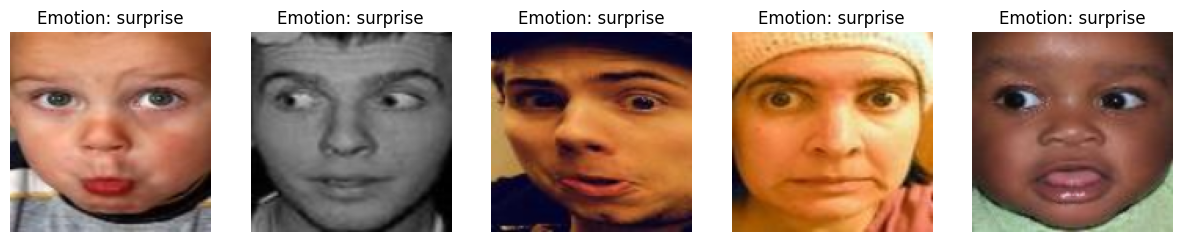

In [18]:
emotion_labels = ["surprise", "fear", "disgust", "happiness", "sadness", "anger", "neutral"]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5 # undo the transform

    axes[i].imshow(img)
    axes[i].set_title(f"Emotion: {emotion_labels[label]}")
    axes[i].axis("off")

plt.show()

In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"training batches: {len(train_loader)}")
print(f"test batches: {len(test_loader)}")

training batches: 384
test batches: 96


### Train ResNet model from scratch

In [21]:
import torch.nn.functional as F

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)

        return out

# full ResNet architecture
class ResNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # blocks for ResNet
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # FC
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7
model = ResNet(num_classes=num_classes).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [22]:
import torch.optim as optim

# use standard cross entropy loss and adam optimizer with lr=0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [23]:
import time
import numpy as np
from tqdm import tqdm

# train from scratch!
num_epochs = 15
train_losses, train_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start_time = time.time()

    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as t:
        for images, labels in t:
            images, labels = images.to(device), labels.to(device)

            # do forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # for metrics tracking
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            t.set_postfix(loss=running_loss / (total / 32), acc=correct / total)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Time: {end_time - start_time:.2f}s")

print("training done!")


Epoch [1/15]: 100%|██████████| 384/384 [00:29<00:00, 12.80batch/s, acc=0.596, loss=1.11]


Epoch [1/15] - Loss: 1.1113, Accuracy: 0.5956, Time: 30.00s


Epoch [2/15]: 100%|██████████| 384/384 [00:27<00:00, 13.88batch/s, acc=0.738, loss=0.729]


Epoch [2/15] - Loss: 0.7282, Accuracy: 0.7383, Time: 27.68s


Epoch [3/15]: 100%|██████████| 384/384 [00:27<00:00, 13.93batch/s, acc=0.817, loss=0.521]


Epoch [3/15] - Loss: 0.5205, Accuracy: 0.8167, Time: 27.57s


Epoch [4/15]: 100%|██████████| 384/384 [00:27<00:00, 13.92batch/s, acc=0.878, loss=0.348]


Epoch [4/15] - Loss: 0.3475, Accuracy: 0.8778, Time: 27.60s


Epoch [5/15]: 100%|██████████| 384/384 [00:28<00:00, 13.57batch/s, acc=0.928, loss=0.213]


Epoch [5/15] - Loss: 0.2125, Accuracy: 0.9279, Time: 28.31s


Epoch [6/15]: 100%|██████████| 384/384 [00:30<00:00, 12.79batch/s, acc=0.952, loss=0.141]


Epoch [6/15] - Loss: 0.1411, Accuracy: 0.9521, Time: 30.04s


Epoch [7/15]: 100%|██████████| 384/384 [00:29<00:00, 12.98batch/s, acc=0.958, loss=0.122]


Epoch [7/15] - Loss: 0.1223, Accuracy: 0.9582, Time: 29.60s


Epoch [8/15]: 100%|██████████| 384/384 [00:28<00:00, 13.59batch/s, acc=0.964, loss=0.1]


Epoch [8/15] - Loss: 0.0999, Accuracy: 0.9643, Time: 28.26s


Epoch [9/15]: 100%|██████████| 384/384 [00:27<00:00, 13.87batch/s, acc=0.972, loss=0.0817]


Epoch [9/15] - Loss: 0.0816, Accuracy: 0.9725, Time: 27.69s


Epoch [10/15]: 100%|██████████| 384/384 [00:27<00:00, 13.78batch/s, acc=0.974, loss=0.0776]


Epoch [10/15] - Loss: 0.0775, Accuracy: 0.9740, Time: 27.86s


Epoch [11/15]: 100%|██████████| 384/384 [00:27<00:00, 13.87batch/s, acc=0.975, loss=0.0718]


Epoch [11/15] - Loss: 0.0717, Accuracy: 0.9748, Time: 27.70s


Epoch [12/15]: 100%|██████████| 384/384 [00:28<00:00, 13.51batch/s, acc=0.972, loss=0.0792]


Epoch [12/15] - Loss: 0.0791, Accuracy: 0.9725, Time: 28.43s


Epoch [13/15]: 100%|██████████| 384/384 [00:27<00:00, 13.86batch/s, acc=0.979, loss=0.0624]


Epoch [13/15] - Loss: 0.0623, Accuracy: 0.9791, Time: 27.70s


Epoch [14/15]: 100%|██████████| 384/384 [00:27<00:00, 13.83batch/s, acc=0.986, loss=0.0416]


Epoch [14/15] - Loss: 0.0415, Accuracy: 0.9861, Time: 27.77s


Epoch [15/15]: 100%|██████████| 384/384 [00:27<00:00, 13.85batch/s, acc=0.984, loss=0.052]

Epoch [15/15] - Loss: 0.0519, Accuracy: 0.9839, Time: 27.73s
training done!


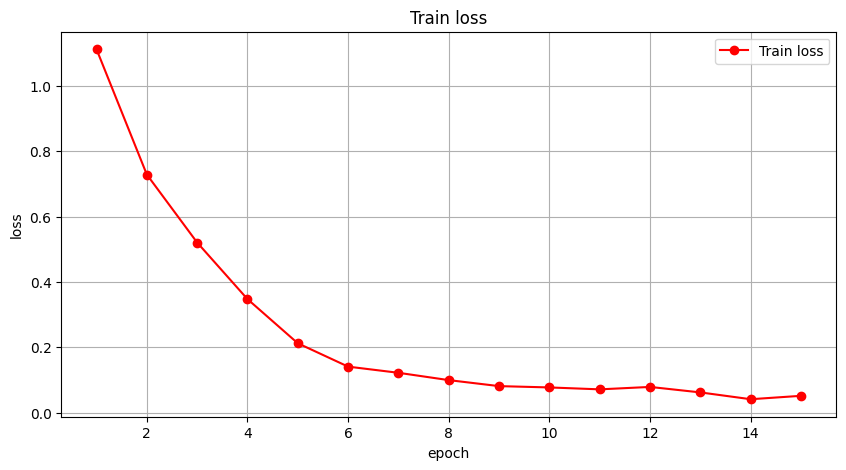

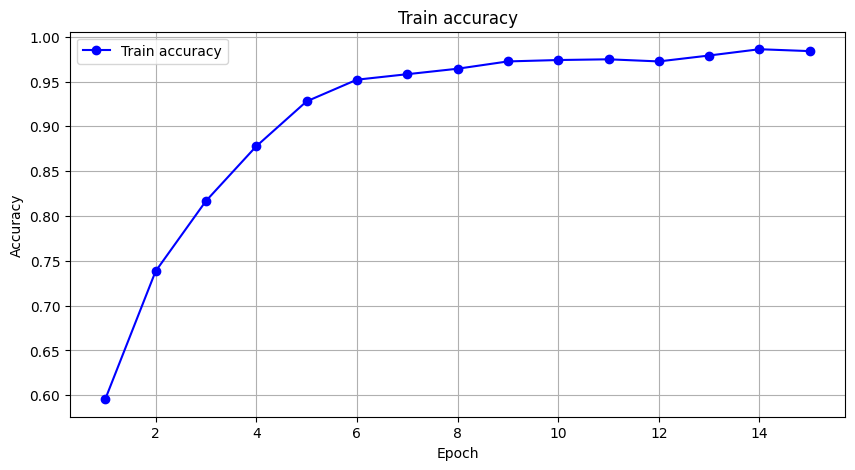

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-', color='r', label="Train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accs, marker='o', linestyle='-', color='b', label="Train accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train accuracy")
plt.legend()
plt.grid()
plt.show()